In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [319]:
def exp_plat(ym, k, x):
    return ym * (1 - np.exp(-k * x))

EIR = np.linspace(1, 100, dtype=np.float32)
k = 5 * 1e-2
ym = .7
prev = exp_plat(ym, k, EIR)

In [320]:
sample_size = 50
EIR_sample = np.random.randint(1,100,sample_size).astype(np.float32)

In [321]:
sigma = 0.05
def bounded(x, l, u):
    return np.minimum(np.maximum(x, l), u)

prev_sample = bounded(exp_plat(ym, k, EIR_sample) + np.random.normal(size=len(EIR_sample), scale=sigma), 0, 1).astype(np.float32)
pop_sample = np.maximum(np.random.normal(size=len(EIR_sample), loc=10000, scale=1000), 0.).astype(np.float32)

Text(0, 0.5, 'prev')

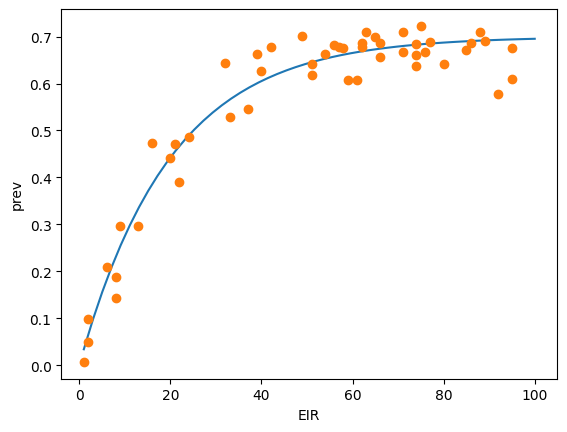

In [322]:
plt.plot(EIR, prev)
plt.plot(EIR_sample, prev_sample, 'o')
plt.xlabel('EIR')
plt.ylabel('prev')

In [323]:
import tensorflow_probability as tfp
tfd = tfp.distributions
from tensorflow.keras.models import load_model
import tensorflow as tf

In [7]:
import matplotlib.pyplot as plt

In [8]:
model = load_model('./models/eq/')

2022-11-01 12:34:10.387048: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-01 12:34:11.283660: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38406 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:27:00.0, compute capability: 8.0
2022-11-01 12:34:11.285467: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38406 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:28:00.0, compute capability: 8.0


In [324]:
default_params = pd.read_csv('default_params.csv')
bounds = pd.read_csv('./outputs/eq/bounds.csv',dtype={'name': str, 'min': np.float32, 'max': np.float32})
bounds_dict = { n: (l, u) for n, l, u in bounds.itertuples(index=False) }
default_dict = dict(default_params.itertuples(index=False))

In [325]:
clipper = tfp.bijectors.SoftClip(bounds['min'], bounds['max'], hinge_softness=1e-10)
pop_sample_tf = tf.constant(pop_sample)

@tf.function
def model_prev(kb, ub, b0, b1, IB0, eir):
    param_shape = kb.shape
    X_ = tf.stack([
        tf.fill(param_shape, default_dict['eta']), # default age
        tf.fill(param_shape, default_dict['Q0']),
        tf.fill(param_shape, default_dict['s2']),
        tf.fill(param_shape, default_dict['rU']),
        tf.fill(param_shape, default_dict['cD']),
        tf.fill(param_shape, default_dict['g_inf']),
        tf.fill(param_shape, default_dict['cU']),
        kb,
        ub,
        tf.fill(param_shape, default_dict['uc']),
        tf.fill(param_shape, default_dict['ud']),
        tf.fill(param_shape, default_dict['kc']),
        b0,
        b1,
        IB0,
        tf.fill(param_shape, default_dict['IC0']),
        tf.fill(param_shape, default_dict['tau']),
        tf.fill(param_shape, default_dict['phi0']),
        tf.fill(param_shape, default_dict['phi1']),
        tf.fill(param_shape, default_dict['mu']),
        tf.fill(param_shape, default_dict['f']),
        tf.fill(param_shape, default_dict['fd0']),
        tf.fill(param_shape, default_dict['ad0']),
        tf.fill(param_shape, default_dict['gd'])
    ], axis=len(param_shape))
    if len(X_.shape) == 1:
        X_ = tf.expand_dims(X_, axis=0)
        eir = tf.expand_dims(eir, axis=0)
    batch_size = X_.shape[0]
    sites = eir.shape[1]
    X_ = tf.repeat(X_, sites, axis=0)
    eir_rep = tf.reshape(eir, (batch_size * sites, 1))
    X = tf.concat([eir_rep, X_], axis=1)
    prev_pred = model(clipper(X))
    return tf.reshape(prev_pred, (batch_size, sites))

@tf.function
def prob_prev(kb, ub, b0, b1, IB0, eir):
    prev_pred = model_prev(kb, ub, b0, b1, IB0, eir)
    return tfd.Independent(
        tfd.Binomial(total_count=pop_sample_tf[tf.newaxis, :], probs=prev_pred),
        reinterpreted_batch_ndims=1,
        name='prev'
    )

In [326]:
from collections import OrderedDict
EIR_sigma = 1
EIR_guesses = bounded(EIR_sample + np.random.normal(size=len(EIR_sample), scale=EIR_sigma).astype(np.float32), 1., 100.)
    
joint_dist = tfp.distributions.JointDistributionNamed(
    OrderedDict(
        kb = tfd.Gamma(4., 1., validate_args=True),
        ub = tfd.LogNormal(1., 1., validate_args=True),
        b0 = tfd.Beta(7., 1., validate_args=True),
        b1 = tfd.Beta(7., 1., validate_args=True),
        IB0 = tfd.Gamma(5., .1, validate_args=True),
        EIR = tfd.Independent(tfd.TruncatedNormal(loc=EIR_guesses, scale=np.full(sample_size, EIR_sigma, dtype=np.float32), low=0, high=100), reinterpreted_batch_ndims=1),
        prev = lambda kb, ub, b0, b1, IB0, EIR : prob_prev(kb, ub, b0, b1, IB0, EIR)
    )
)

In [328]:
*prior_samples, prior_predictive = joint_dist.sample(1000).values()

In [266]:
import arviz as az

In [329]:
prior_trace = az.from_dict(
    observed_data={"observations": pop_sample * prev_sample},
    prior_predictive={"observations": prior_predictive[tf.newaxis, ...]},
    coords={"observation": np.arange(sample_size)},
    dims={"observations": ["observation"]},
)
print(prior_trace.prior_predictive)

<xarray.Dataset>
Dimensions:       (chain: 1, draw: 1000, observation: 50)
Coordinates:
  * chain         (chain) int64 0
  * draw          (draw) int64 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * observation   (observation) int64 0 1 2 3 4 5 6 7 ... 43 44 45 46 47 48 49
Data variables:
    observations  (chain, draw, observation) float32 7.422e+03 ... 6.853e+03
Attributes:
    created_at:     2022-11-01T16:39:47.502374
    arviz_version:  0.13.0


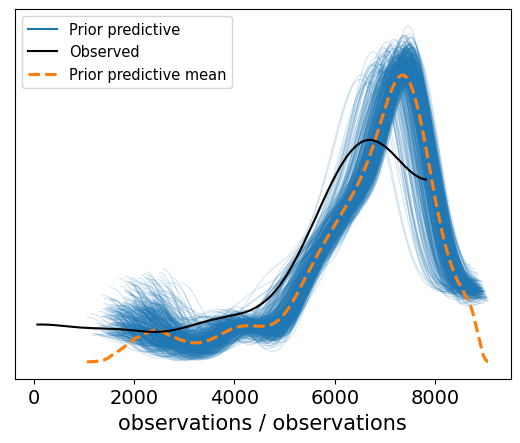

In [330]:
ax = az.plot_ppc(prior_trace, group="prior", num_pp_samples=500)

<Figure size 640x480 with 0 Axes>

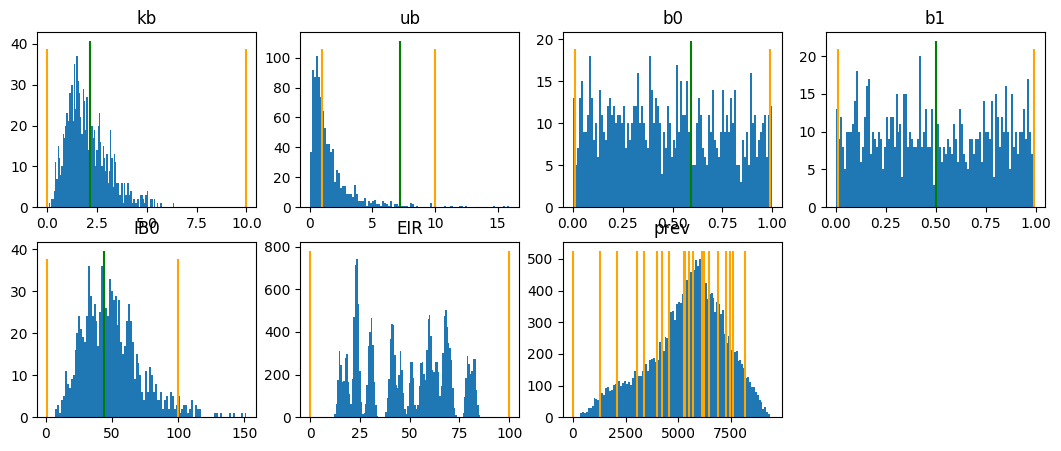

In [296]:
#raise Error()
cols = 4
rows = (len(prior) // cols + 1)
prior_keys = list(prior.keys())
plt.tight_layout()
fig, axes = plt.subplots(rows, cols, figsize=(cols * rows + 5, 5))
for c in range(cols):
    for r in range(rows):
        if cols * r + c < len(prior_keys):
            ax = axes[r][c]
            k = prior_keys[cols * r + c]
            ax.hist(prior[k].numpy().flatten(), bins=100)
            if k in bounds_dict.keys():
                ax.vlines(bounds_dict[k], 0, ax.get_ylim()[1], color='orange')
            if k in default_dict.keys():
                ax.vlines(default_dict[k], 0, ax.get_ylim()[1], color='green')
            elif k == 'eir':
                ax.vlines(EIR_sample, 0, ax.get_ylim()[1], color='orange')
            elif k == 'prev':
                ax.vlines(prev_sample * pop_sample, 0, ax.get_ylim()[1], color='orange')
            ax.set_title(k)
        else:
            fig.delaxes(axes[r][c])

In [ ]:
%%time
# Initialize the HMC transition kernel.
tf.config.experimental.enable_tensor_float_32_execution(False)
num_results = 100 #int(1e3)
num_burnin_steps = 100 #int(1e3)

num_chains = 10

pinned_joint_dist_r = joint_dist_r.experimental_pin(prev = observed_prev)
initial_state_dict = pinned_joint_dist_r.sample_unpinned(num_chains)
initial_state = list(initial_state_dict.values())

initial_step_size = [
    tf.constant(1e-3, shape=[num_chains] + [1] * (len(x.shape) - 1))
    for x in initial_state
]

def log_prob_r(*state):
    return pinned_joint_dist_r.unnormalized_log_prob(state)

mcmc = tfp.mcmc.TransformedTransitionKernel(
    tfp.mcmc.SimpleStepSizeAdaptation(
        inner_kernel = tfp.mcmc.HamiltonianMonteCarlo(
            target_log_prob_fn=log_prob_r,
            num_leapfrog_steps=50,
            step_size=initial_step_size
        ),
        num_adaptation_steps=int(num_burnin_steps * 0.8)
    ),
    pinned_joint_dist_r.experimental_default_event_space_bijector().bijectors
)

def run_chain():
    return tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=initial_state,
      parallel_iterations=num_chains,
      kernel=mcmc,
      trace_fn=lambda _, pkr: pkr.inner_results.inner_results.is_accepted
    )

samples, acceptance = run_chain()

In [376]:
acceptance.numpy().mean()

0.887

In [377]:
parameter_names = pinned_joint_dist._flat_resolve_names()

In [378]:
posterior_predictive = tf.concat([list(joint_dist.sample(value=dict(zip(parameter_names, [s[:,chain,...] for s in samples]))).values())[-1][tf.newaxis, ...] for chain in range(num_chains)], 0)

In [379]:
trace = az.from_dict(
    prior={k: v[tf.newaxis, ...] for k, v in zip(parameter_names, prior_samples)},
    posterior={
        k: np.swapaxes(v, 0, 1) for k, v in zip(parameter_names, samples)
    },
    prior_predictive={"observations": prior_predictive[tf.newaxis, ...]},
    posterior_predictive={"observations": posterior_predictive},
    coords={"observation": np.arange(sample_size), "param": np.arange(len(parameter_names))},
    observed_data={"observations": pop_sample * prev_sample},
    dims={"observations": ["observation"], "coefficients": ["param"]},
)

print(trace)

Inference data with groups:
	> posterior
	> posterior_predictive
	> prior
	> prior_predictive
	> observed_data


In [380]:
print(az.summary(trace).filter(items=["mean", "hdi_3%", "hdi_97%", "ess_mean", "r_hat"]))

           mean  hdi_3%  hdi_97%  r_hat
kb        1.109   0.043    7.095   2.84
ub       18.586   8.446   56.246   2.35
b0        0.477   0.366    0.995   4.36
b1        0.734   0.008    0.993   3.29
IB0      50.993  18.894   67.120   5.55
EIR[0]   95.369  93.372   97.492   1.57
EIR[1]   52.701  50.707   54.477   1.11
EIR[2]   54.250  50.624   56.804   1.64
EIR[3]    0.006   0.001    0.013   2.25
EIR[4]    6.529   2.571    7.789   2.14
EIR[5]   87.888  86.023   89.731   1.09
EIR[6]   91.471  87.110   97.592   2.25
EIR[7]    0.017   0.002    0.034   2.61
EIR[8]   77.227  75.325   78.919   1.01
EIR[9]   42.546  38.752   44.663   1.39
EIR[10]  58.568  56.572   60.662   1.12
EIR[11]  33.361  29.665   36.056   1.69
EIR[12]  56.738  54.445   58.730   1.18
EIR[13]  16.231   6.997   18.989   2.03
EIR[14]   3.094   1.547    3.674   1.93
EIR[15]   0.456   0.014    0.723   2.05
EIR[16]  71.518  69.787   73.283   1.01
EIR[17]  63.596  61.665   65.595   1.08
EIR[18]  62.424  60.422   64.467   1.14


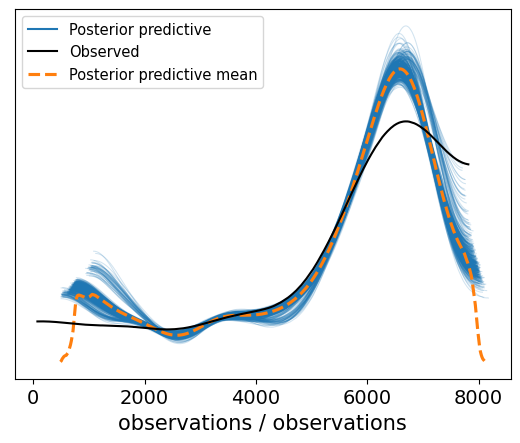

In [381]:
ax = az.plot_ppc(trace, group="posterior", num_pp_samples=500)

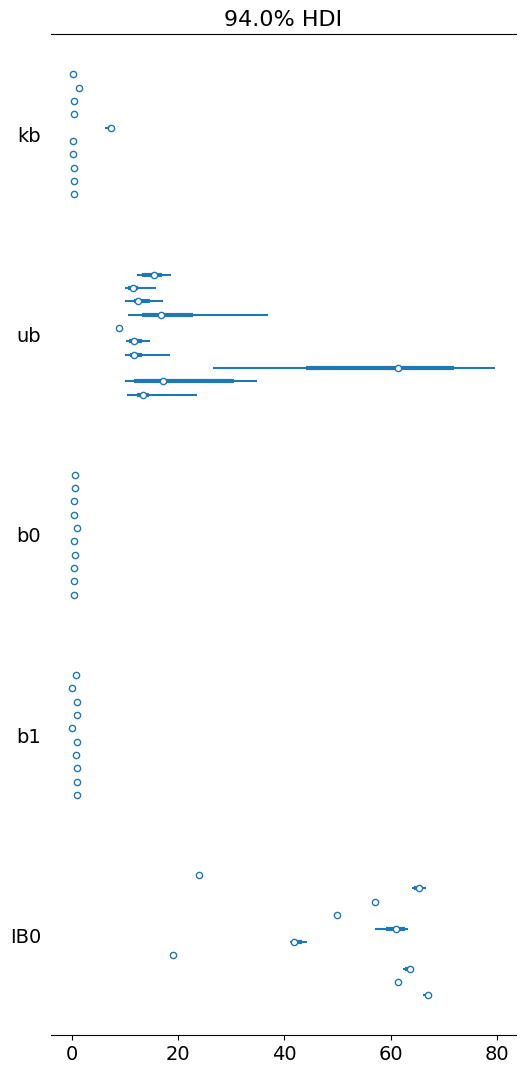

In [382]:
axs = az.plot_forest(trace, var_names=['kb', 'ub', 'b0', 'b1', 'IB0'])

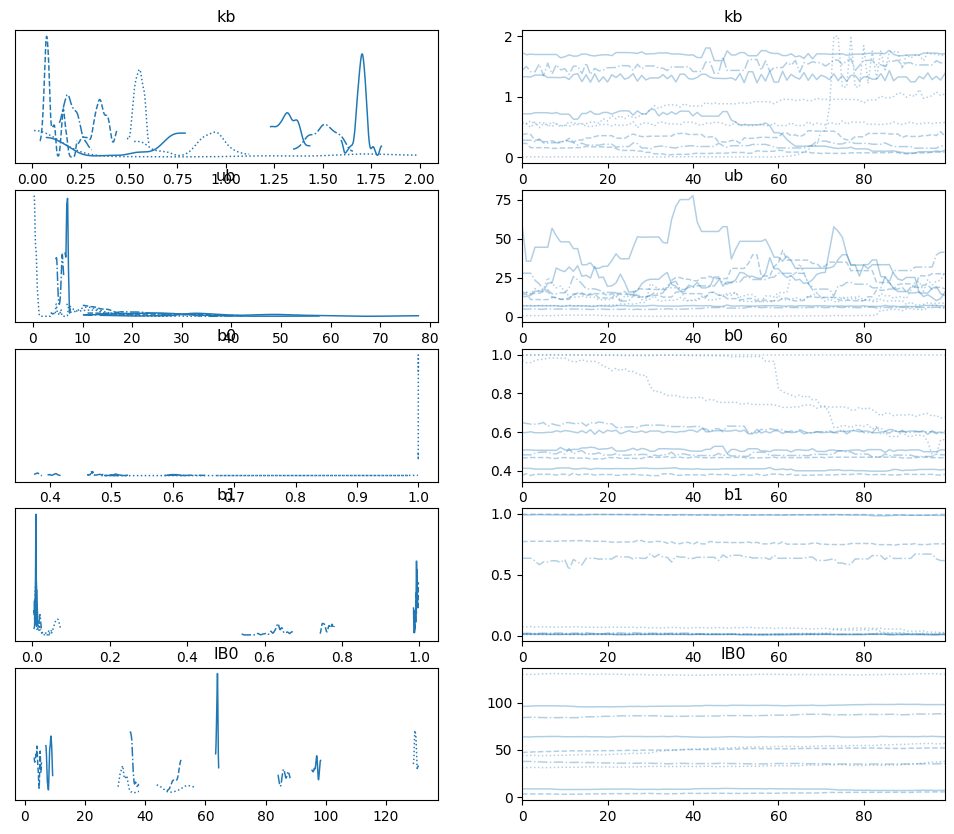

In [373]:
axs = az.plot_trace(trace, var_names=['kb', 'ub', 'b0', 'b1', 'IB0'])

In [383]:
posterior = dict(zip(initial_state_dict.keys(), samples))

<Figure size 640x480 with 0 Axes>

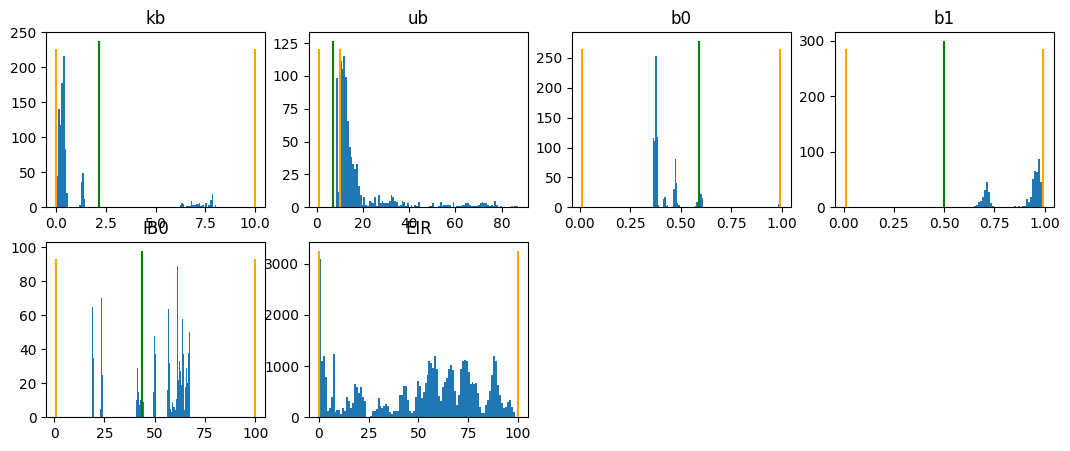

In [384]:
cols = 4
rows = (len(posterior) // cols + 1)
posterior_keys = list(posterior.keys())
bounds_dict = { n: (l, u) for n, l, u in bounds.itertuples(index=False) }
plt.tight_layout()
fig, axes = plt.subplots(rows, cols, figsize=(cols * rows + 5, 5))
for c in range(cols):
    for r in range(rows):
        if cols * r + c < len(posterior_keys):
            ax = axes[r][c]
            k = posterior_keys[cols * r + c]
            ax.hist(posterior[k].numpy().flatten(), bins=100)
            if k in bounds_dict.keys():
                ax.vlines(bounds_dict[k], 0, ax.get_ylim()[1], color='orange')
            elif k == 'eir':
                ax.vlines(EIR_sample, 0, ax.get_ylim()[1], color='orange')
            if k in default_dict.keys():
                ax.vlines(default_dict[k], 0, ax.get_ylim()[1], color='green')
            ax.set_title(k)
        else:
            fig.delaxes(axes[r][c])

<Figure size 640x480 with 0 Axes>

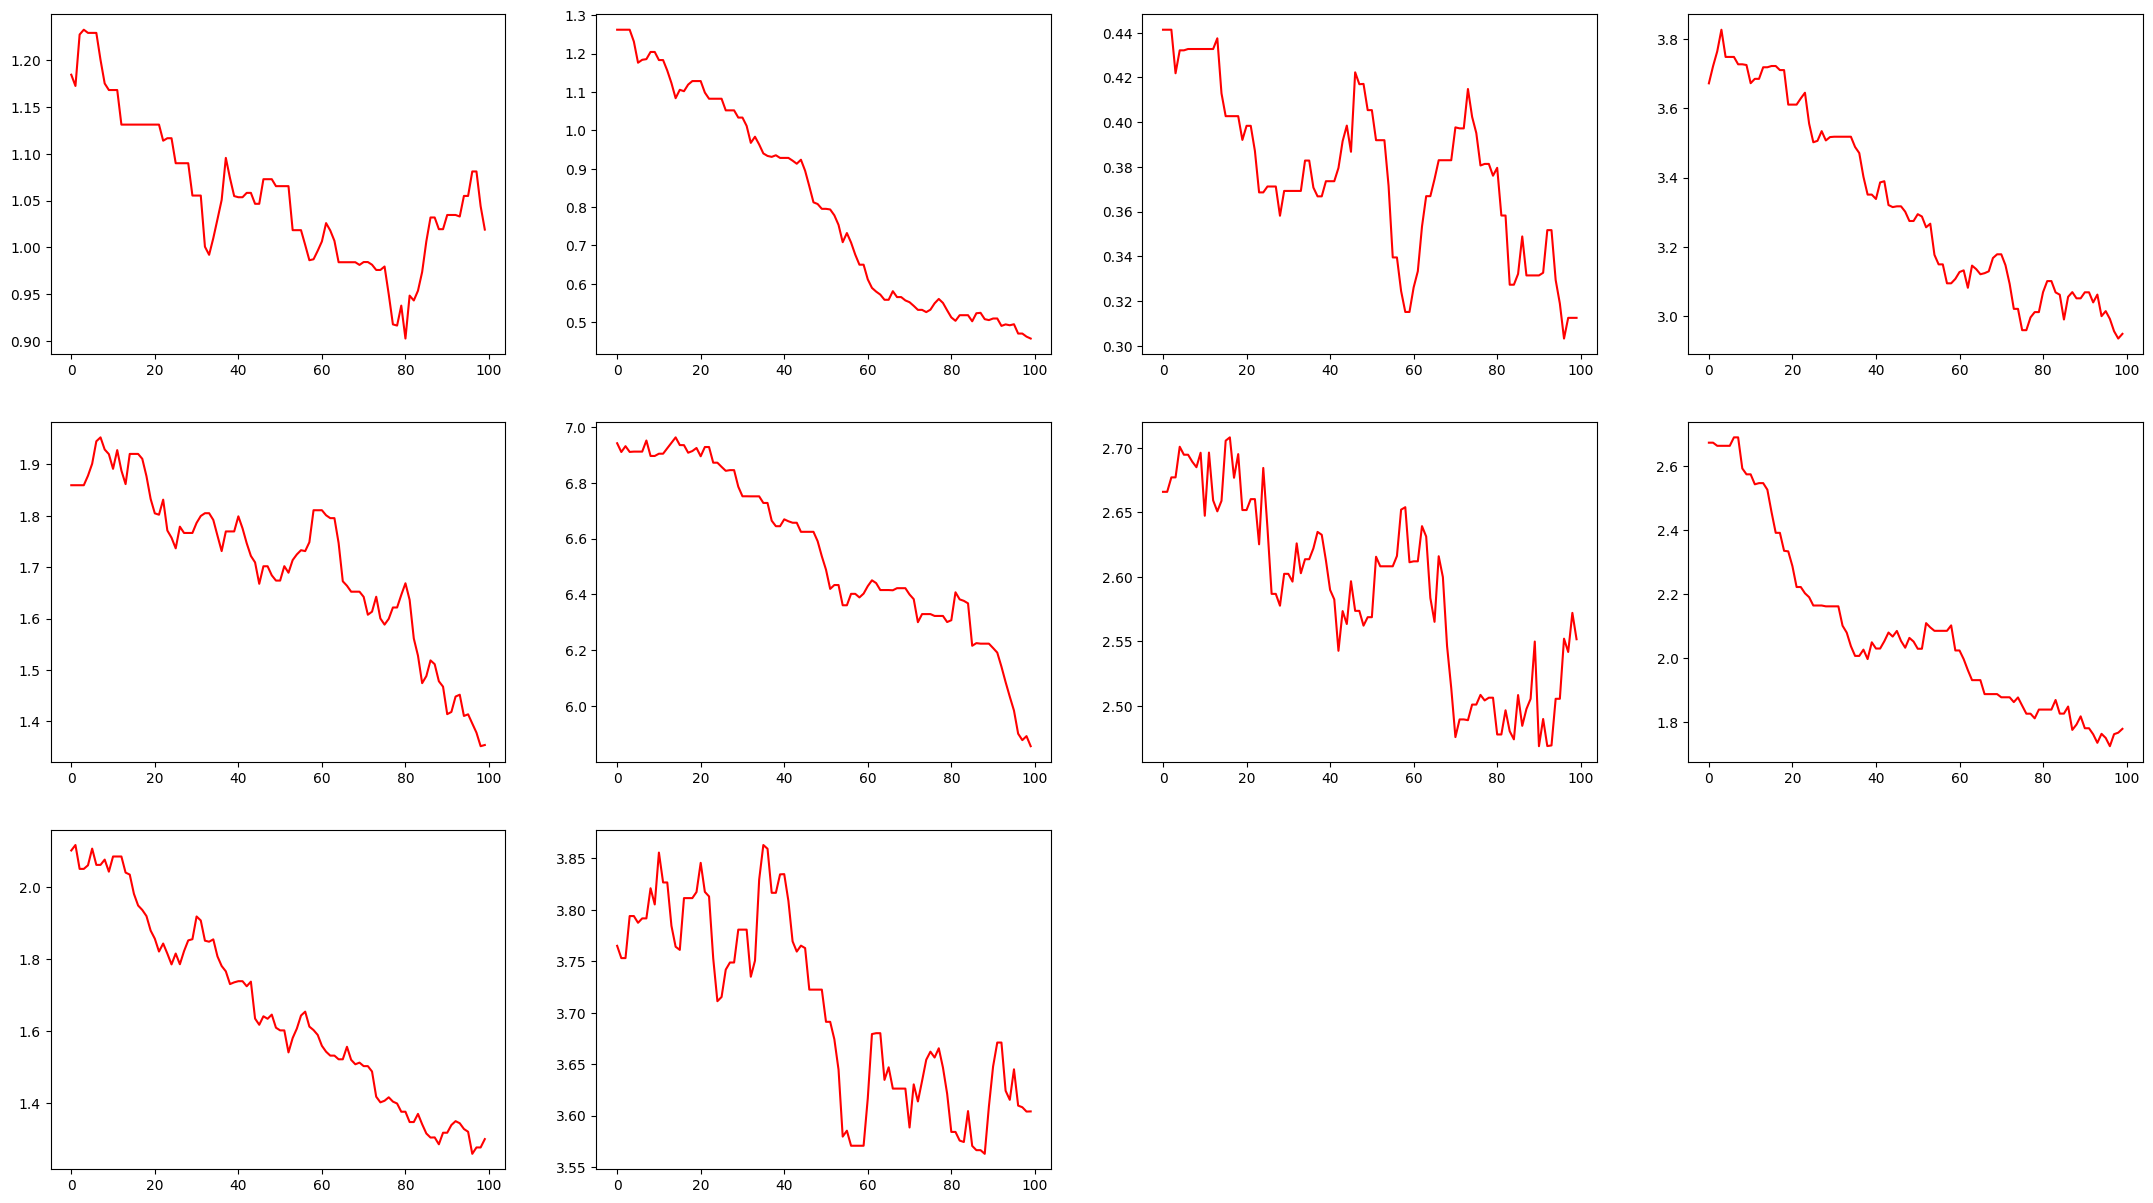

In [279]:
variable = 0
cols = 4
rows = (num_chains // cols + 1)
plt.tight_layout()
fig, axes = plt.subplots(rows, cols, figsize=(cols * rows + 15, 15))
for c in range(cols):
    for r in range(rows):
        if len(axes.shape) == 1:
            ax = axes[c]
        else:
            ax = axes[r][c]
        i = cols * r + c
        if i < num_chains:
            ax.plot(samples[variable][:, i:i + 1], color='red')
        else:
            fig.delaxes(ax)

(array([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  1.],
        [50.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.]]),
 array([2.11755681e+00, 6.97280945e+02, 1.39244434e+03, 2.08760767e+03,
        2.78277100e+03, 3.47793433e+03, 4.17309766e+03, 4.86826123e+03,
        5.56342432e+03, 6.25858789e+03, 6.95375098e+03, 7.64891455e+03,
        8.34407812e+03, 9.03924121e+03, 9.73440430e+03, 1.04295684e+

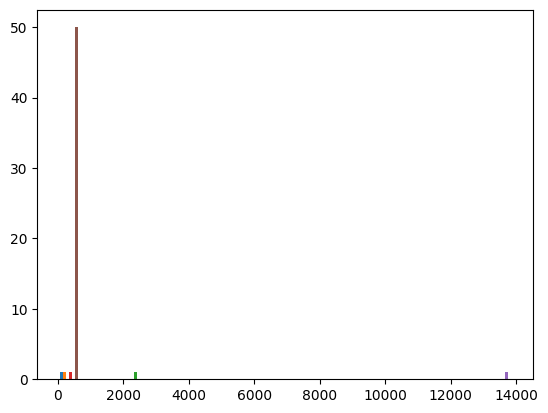

In [335]:
plt.hist(tfp.mcmc.potential_scale_reduction(samples), bins=20)

In [336]:
tfp.mcmc.potential_scale_reduction(samples)

[<tf.Tensor: shape=(), dtype=float32, numpy=83.5312>,
 <tf.Tensor: shape=(), dtype=float32, numpy=16.933573>,
 <tf.Tensor: shape=(), dtype=float32, numpy=2149.009>,
 <tf.Tensor: shape=(), dtype=float32, numpy=236.48454>,
 <tf.Tensor: shape=(), dtype=float32, numpy=13905.385>,
 <tf.Tensor: shape=(50,), dtype=float32, numpy=
 array([ 10.710046 ,  15.777975 ,  12.692931 ,   2.966445 , 111.75598  ,
         10.960857 ,   9.763073 ,   4.2560735,   7.860901 ,  15.09038  ,
          6.2519517,  12.706726 ,   4.1204348, 112.99267  ,  51.48278  ,
         16.915834 ,   3.9415274,   4.0826163,   4.1029987,   8.318531 ,
        109.99985  ,  12.461017 ,  22.761599 ,   8.776797 ,  58.258682 ,
          4.877744 ,   3.8683379, 221.3657   ,   3.073891 ,   8.402253 ,
          5.353343 ,   9.006002 ,  44.351032 ,  45.44587  ,   2.1175568,
          5.3978505,  24.55932  ,  67.283035 ,   4.535808 ,  51.025608 ,
          2.750064 ,   3.4755945,   3.5778227,   4.752894 ,   4.754856 ,
          8.120264

In [385]:
from rpy2.robjects.packages import importr
import rpy2.robjects as ro
import copy
eq = importr('malariaEquilibrium')
r_default_params = eq.load_parameter_set()
ages = ro.FloatVector(range(100))

In [393]:
def single_prev(params, eir):
    states = eq.human_equilibrium(eir, ft = 0., p=params, age=ages)
    return sum(states.rx2['states'].rx(ro.IntVector(range(4,11)),'pos_M')) / sum(states.rx2['states'].rx(ro.IntVector(range(4,11)),'prop'))

def model_prev_r(kb, ub, b0, b1, IB0, eir):
    params = [kb, ub, b0, b1, IB0, eir]
    if len(kb.shape) == 0:
        return 0
        params = [tf.expand_dims(p, axis=0) for p in params]
        eir = tf.expand_dims(eir, axis=0)
    batch_size = params[0].shape[0]
    sites = eir.shape[1]
    prev = np.zeros((batch_size, sites), dtype=np.float32)
    for b in range(batch_size):
        for n, p in zip(['kb', 'ub', 'b0', 'b1', 'IB0'], params):
            batch_params = copy.deepcopy(r_default_params)
            batch_params.rx2[n] = ro.FloatVector([p[b].numpy()])
        for e_i, e in enumerate(eir[b, :]):
            prev[b, e_i] = single_prev(batch_params, ro.FloatVector([e.numpy()]))
    return prev

def prob_prev_r(kb, ub, b0, b1, IB0, eir):
    prev_pred = model_prev_r(kb, ub, b0, b1, IB0, eir)
    return tfd.Independent(
        tfd.Binomial(total_count=pop_sample_tf[tf.newaxis, :], probs=prev_pred),
        reinterpreted_batch_ndims=1
    )

In [391]:
joint_dist_r = tfp.distributions.JointDistributionNamed(
    OrderedDict(
        kb = tfd.Gamma(4., 1., validate_args=True),
        ub = tfd.LogNormal(1., 1., validate_args=True),
        b0 = tfd.Beta(7., 1., validate_args=True),
        b1 = tfd.Beta(7., 1., validate_args=True),
        IB0 = tfd.Gamma(5., .1, validate_args=True),
        EIR = tfd.Independent(tfd.TruncatedNormal(loc=EIR_guesses, scale=np.full(sample_size, EIR_sigma, dtype=np.float32), low=0, high=100), reinterpreted_batch_ndims=1),
        prev = lambda kb, ub, b0, b1, IB0, EIR : prob_prev_r(kb, ub, b0, b1, IB0, EIR)
    )
)

In [394]:
*prior_samples, prior_predictive = joint_dist_r.sample(1000).values()

In [395]:
prior_trace_r = az.from_dict(
    observed_data={"observations": pop_sample * prev_sample},
    prior_predictive={"observations": prior_predictive[tf.newaxis, ...]},
    coords={"observation": np.arange(sample_size)},
    dims={"observations": ["observation"]},
)
print(prior_trace.prior_predictive)

<xarray.Dataset>
Dimensions:       (chain: 1, draw: 1000, observation: 50)
Coordinates:
  * chain         (chain) int64 0
  * draw          (draw) int64 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * observation   (observation) int64 0 1 2 3 4 5 6 7 ... 43 44 45 46 47 48 49
Data variables:
    observations  (chain, draw, observation) float32 7.422e+03 ... 6.853e+03
Attributes:
    created_at:     2022-11-01T16:39:47.502374
    arviz_version:  0.13.0


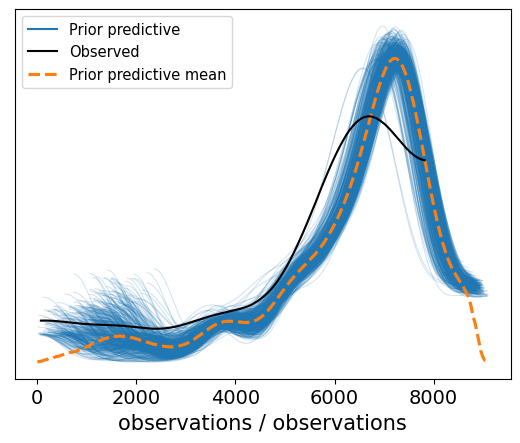

In [396]:
ax = az.plot_ppc(prior_trace_r, group="prior", num_pp_samples=500)

In [ ]:
%%time
# Initialize the HMC transition kernel.
tf.config.experimental.enable_tensor_float_32_execution(False)
num_results = 100 #int(1e3)
num_burnin_steps = 100 #int(1e3)

num_chains = 10

pinned_joint_dist_r = joint_dist_r.experimental_pin(prev = observed_prev)
initial_state_dict = pinned_joint_dist_r.sample_unpinned(num_chains)
initial_state = list(initial_state_dict.values())

initial_step_size = [
    tf.constant(1e-3, shape=[num_chains] + [1] * (len(x.shape) - 1))
    for x in initial_state
]

def log_prob_r(*state):
    return pinned_joint_dist_r.unnormalized_log_prob(state)

mcmc = tfp.mcmc.TransformedTransitionKernel(
    tfp.mcmc.SimpleStepSizeAdaptation(
        inner_kernel = tfp.mcmc.HamiltonianMonteCarlo(
            target_log_prob_fn=log_prob_r,
            num_leapfrog_steps=50,
            step_size=initial_step_size
        ),
        num_adaptation_steps=int(num_burnin_steps * 0.8)
    ),
    pinned_joint_dist_r.experimental_default_event_space_bijector().bijectors
)

def run_chain():
    return tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=initial_state,
      parallel_iterations=num_chains,
      kernel=mcmc,
      trace_fn=lambda _, pkr: pkr.inner_results.inner_results.is_accepted
    )

samples, acceptance = run_chain()

In [ ]:
samples